In [1]:
import pickle
import numpy as np
import glob
import pickle
import matplotlib
import matplotlib.backends.backend_tkagg
#from mmetro_v7 import Mmetro_Utils
import matplotlib.pyplot as plt
import scipy.signal as signal
import scipy.stats as stats
import random
import matplotlib.animation as animation
import scipy as scipy

In [61]:
# Generates the hanning window 
def hanning(M, *varargin):
    m = np.linspace(-(M-1)/2,(M-1)/2,M)  
    Win = 0.5 + 0.5*np.cos(2*np.pi*m/M)
    if len(varargin) == 1:
        N = varargin[0]
        Win = np.broadcast_to(Win,(N,M)).T
    if len(varargin) == 2: 
        N = varargin[0]
        K = varargin[1]
        Win = Win[:, None, None]                # shape (M, 1, 1)
        Win = np.broadcast_to(Win, (M, N, K))
    return Win

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

def frameReshape(frame, numLoopsPerFrame, numRxAntennas):  #
    frameWithChirp = np.reshape(frame, (-1, numLoopsPerFrame, numRxAntennas), order='F')
    return frameWithChirp

# Modified this such that it expects (N x Nrx) size now instead of a 1D array of size N 
def get_RP(data, freq_min, freq_max, nfft=2**8, fs=1e6, bg_sub=True, num_rx=4, num_tx=1):
    # data comes reshaped 

    # background subtraction
    if bg_sub:
        for i in range(4):
            data[:,:, i] = data[:, :, i] - data[:,0, i][:,None]
        # data = data - data[..., 0][:, :, None]

    # normalization
    # earlier: for each frame, normalize the data. Now I have to do that for each frame and each antenna 
    # earlier: 
    # for i in range(data.shape[1]):
        # data[:,i] = data[:,i] - data[:,i].mean()
    for i in range(data.shape[1]):
        for j in range(data.shape[2]):
            data[:,i, j] = data[:,i, j] - data[:,i, j].mean()

    # hanning window used for getting RP 
    Win3D = hanning(data.shape[0], data.shape[1], data.shape[2])        # samples x frame_size x Rx_antennas (radar cube)

    RP = signal.zoom_fft(np.multiply(data, Win3D), fn=[freq_min,freq_max], m=nfft, axis=0, fs=fs)
    return RP

def get_RD(RP):
    # RP : (samples x frame_size) [old]
    # RP : (samples x frame_size x Rx_antennas) [new]
    # WinVel2D = hanning(int(frame_size), nfft)       # want to window on the doppler axis (chirps --> frame_size [256]) 
    # WinVel2D = WinVel2D.transpose()                 # hence the transpose 
    WinVel3D = hanning(RP.shape[1], RP.shape[0], RP.shape[2])   # frame_size x samples x Rx_antennas
    WinVel3D = WinVel3D.transpose(1, 0, 2)                      # samples x frame_size x Rx_antennas

    # getting RD
    RPExt = RP
    for i in range(RPExt.shape[2]):                                # loop over the antennas
        RPExt[:, :, i] = RPExt[:, :, i] - np.mean(RPExt[:, :, i], axis=1)[:,np.newaxis] 

    # np.multipy() --> element-wise multiplication
    RD = np.fft.fft(np.multiply(RPExt, WinVel3D), n=nfft, axis=1)
    RD = np.fft.fftshift(RD, axes=(1,))
    RD[:,116:140, :] = 0 # removing middle doppler noise
    return RD

def angle_fft(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

# Template matching for sinc pattern in RD 
def generate_template(period, frame_size, f_tag, nfft=2**8, tag_duty_cycle=0.5):
    # period = Tc (chrip time)
    # frame size = Nc (#chirps in a frame)
    # nfft = 256 = Ns (number of samples, also the number of points in the FFT)

    # generating a time vector with values for each chirp (period)
    t = np.arange(0, period*frame_size, period)

    # generating a square wave during that time with the given duty cycle 
    sq_wav = signal.square(2*np.pi*f_tag*t, tag_duty_cycle)

    # the template is the FFT of the square wave
    sq_wav_fft = np.fft.fftshift(np.fft.fft(sq_wav, n=nfft, axis=0))
    return sq_wav_fft


def get_range(frame_idx, data_raw, antenna_pick, frame_size, N, chirp_slope, period, range_min, range_max, f_tag, fs=1e6, nfft=2**8):
    data_single_chn = data_raw[:,:,antenna_pick] # select one channel (antena)
    data_snapshot = data_single_chn[:,frame_idx] # select the frame

    # define frequency max and min
    freq_min = 2*range_min * chirp_slope / c
    freq_max = 2*range_max * chirp_slope / c
    
    # get the range profile 
    RP = get_RP(data=data_snapshot, \
                frame_size=frame_size, 
                N=N, 
                freq_min=freq_min, 
                freq_max=freq_max, 
                nfft=nfft,
                fs=fs,
                bg_sub=True)

    # get the range-doppler
    RD = get_RD(RP, frame_size=frame_size, nfft=nfft)

    # Template matching code
    # 400 is the number of frequency steps 
    csweep = np.zeros(400)
    # corr_240 = 0
    # corr_332 = 0
    # for fstep in range(0,400):
    #     # generate the template for fstep'th frequency step 
    #     template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=fstep)

    #     # bunch of stuff happening here, but basically applying the template (currently (N,)) through the entire range axis and then taking dot product with the RD
    #     # template[:, np.newaxis]                                  --> changes shape from (N,) to (N,1)
    #     # np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1) --> copies the template in all the range bins 
    #     correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1)
        
    #     # stores the max value for that frequency 
    #     csweep[fstep] = np.max(correlation)
    
    # Trying to locate the tag -- get indexes for the tags
    # --- why 4 faces? Top face and face D share the same control signal 
    f_tags = [183, 337, 250, 127]
    max_idxs = np.zeros(4)
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        correlation = np.sum(np.abs(RD) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)
    return RP, RD, csweep, max_idxs, range_steps

def angle_fft_windowless(RD_cube, nfft, d_over_lambda=0.5, window=np.hanning):
    """
    RD_cube : (R, D, N_rx)
    returns
        theta      : (Nfft_ang,) angle grid in radians
        P_ang_cube : (R, D, Nfft_ang) power spectrum
    """
    # num_tx = 3 
    R, D, N_rx = RD_cube.shape
    WinAng3D = hanning(N_rx, R, D)          # rx_antennas x range_bins (samples) x frame_size 
    WinAng3D = WinAng3D.transpose(1, 2, 0)  # R x D x N_rx
    WinAng3D = np.ones_like(WinAng3D)       # just make it ones 

    AoA = np.fft.fftshift(np.fft.fft(np.multiply(RD_cube, WinAng3D), n=nfft, axis=2), axes=2)
    AoA_db = 20.0 * np.log10(np.abs(AoA) + 1e-12)
    AoA_norm = AoA_db - AoA_db.max()
    AoA_norm[AoA_norm < -25.0] = -25.0
    return AoA_norm

In [62]:
antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
range_min = 0
range_max = 5
num_rx = 4
num_tx = 1


In [63]:
def get_angle_framewise(frame, freq_min, freq_max, chirp_slope, period, frame_size, f_tags = [183, 337, 250, 127], nfft=2**8, num_rx=4, c=2.98e8):
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max)
    RD = get_RD(RP)
    AOA_norm = angle_fft(RD, nfft=64)
    # f_tags = [183, 337, 250, 127]
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)

    max_idxs = max_idxs.astype(int)
    target_idx = int(np.mean(max_idxs))
    RD_slice = np.abs(RD[target_idx, :, 0])
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    f_tags = np.array(f_tags)
    diff = np.abs(doppler_freqs[None, :] - f_tags[:, None])

    # For each f_tag (row), find the index of the closest doppler_freq
    closest_doppler_indices = np.argmin(diff, axis=1)
    AoA_vals = np.linspace(-45, 45, num=64) # 64-point FFT 
 
    freq_aoa_dict = {}
    for i in range(len(closest_doppler_indices)):
        target_freq_idx = closest_doppler_indices[i] 
        AoA_range_freq = AOA_norm[target_idx, target_freq_idx, :]
        AoA_idx = np.argmax(AoA_range_freq)
        AoA = AoA_vals[AoA_idx]
        freq_aoa_dict[doppler_freqs[target_freq_idx]] = AoA

    aoa_list = np.array(list(freq_aoa_dict.values()))
    mode_aoa = scipy.stats.mode(aoa_list[aoa_list!=-45]).mode
    mean_aoa = np.mean(aoa_list[aoa_list!=-45])
    return mean_aoa, mode_aoa, aoa_list


In [64]:
filename = "/nas-data/soham/drone-landing/test_20cm_across_aoa_16_to_24deg-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

mode_AoA_array = []
mean_AoA_array = []
for i in range(2, 89):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)

frame = 2, aoa_list = [-45.          12.14285714  10.71428571  10.71428571]
frame = 3, aoa_list = [-45.          12.14285714  10.71428571  12.14285714]
frame = 4, aoa_list = [-45.          12.14285714  10.71428571  12.14285714]
frame = 5, aoa_list = [-45.          12.14285714  10.71428571 -45.        ]
frame = 6, aoa_list = [-45.          12.14285714  10.71428571  12.14285714]
frame = 7, aoa_list = [-45.          12.14285714  12.14285714  10.71428571]
frame = 8, aoa_list = [19.28571429 12.14285714 12.14285714 13.57142857]
frame = 9, aoa_list = [ 16.42857143  12.14285714  12.14285714 -45.        ]
frame = 10, aoa_list = [-45.          13.57142857  10.71428571  13.57142857]
frame = 11, aoa_list = [-45.          13.57142857  12.14285714  13.57142857]
frame = 12, aoa_list = [-45.          12.14285714  12.14285714  13.57142857]
frame = 13, aoa_list = [-45.          12.14285714  12.14285714  12.14285714]
frame = 14, aoa_list = [-45.          12.14285714  12.14285714  19.28571429]
frame = 15,

Text(0.5, 1.0, '/nas-data/soham/drone-landing/test_20cm_across_aoa_16_to_24deg-24GHz.pickle: Mode')

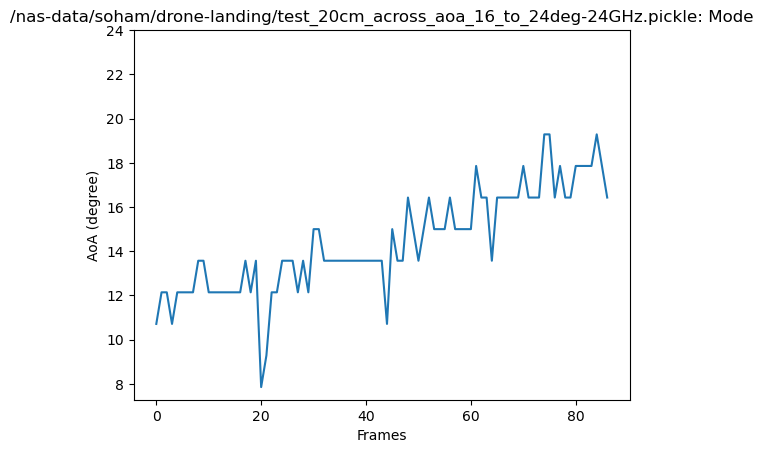

In [65]:
plt.plot(mode_AoA_array)
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks([8, 10, 12, 14, 16, 18, 20, 22, 24])
plt.title(f"{filename}: Mode")

Text(0.5, 1.0, '/nas-data/soham/drone-landing/test_20cm_across_aoa_16_to_24deg-24GHz.pickle: Mean')

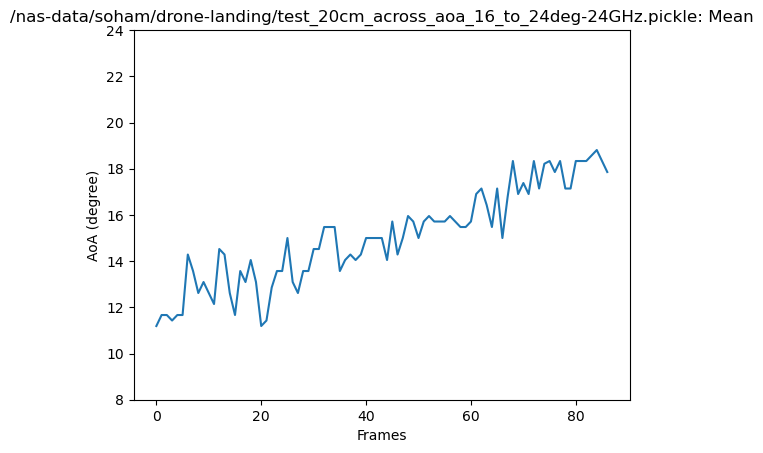

In [66]:
plt.plot(mean_AoA_array)
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks([8, 10, 12, 14, 16, 18, 20, 22, 24])
plt.title(f"{filename}: Mean")

In [69]:
filename = "/nas-data/soham/drone-landing/test_20cm_across_aoa_0_to_8deg-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']

# data_raw.shape

antenna_pick = 1
nfft = 2**8
fs = 1e6
c = 2.98e8
num_rx = 4
num_tx = 1

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

mode_AoA_array = []
mean_AoA_array = []
for i in range(2, 89):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)

frame = 2, aoa_list = [ 0.71428571  0.71428571 -2.14285714 -0.71428571]
frame = 3, aoa_list = [ 0.71428571  0.71428571 -0.71428571 -0.71428571]
frame = 4, aoa_list = [ 2.14285714  0.71428571 -0.71428571 -0.71428571]
frame = 5, aoa_list = [ 0.71428571  0.71428571 -0.71428571  0.71428571]
frame = 6, aoa_list = [ 0.71428571  0.71428571 -2.14285714  0.71428571]
frame = 7, aoa_list = [ 2.14285714  0.71428571 -2.14285714 -2.14285714]
frame = 8, aoa_list = [  0.71428571   0.71428571  -2.14285714 -45.        ]
frame = 9, aoa_list = [ 2.14285714  0.71428571 -2.14285714 -2.14285714]
frame = 10, aoa_list = [ 0.71428571  0.71428571 -0.71428571 -2.14285714]
frame = 11, aoa_list = [ 0.71428571  0.71428571 -0.71428571  2.14285714]
frame = 12, aoa_list = [ 3.57142857  0.71428571 -2.14285714 -3.57142857]
frame = 13, aoa_list = [ 3.57142857  0.71428571 -0.71428571  3.57142857]
frame = 14, aoa_list = [  3.57142857   0.71428571  -0.71428571 -45.        ]
frame = 15, aoa_list = [ 0.71428571  0.71428571 -0.

Text(0.5, 1.0, '/nas-data/soham/drone-landing/test_20cm_across_aoa_0_to_8deg-24GHz.pickle: Mode')

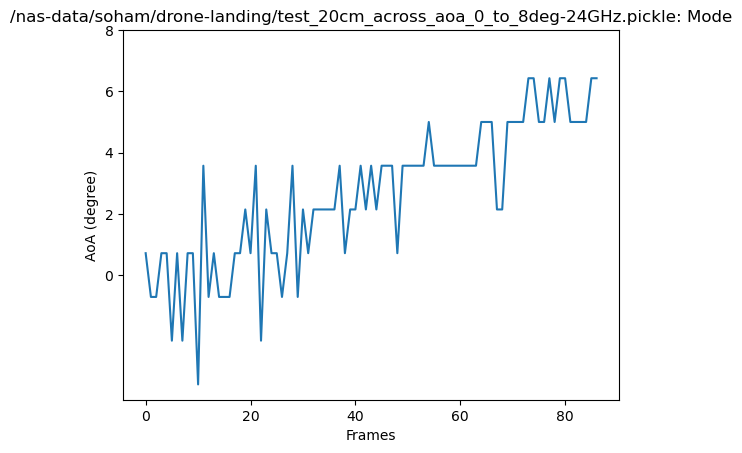

In [70]:
plt.plot(mode_AoA_array)
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks([0, 2, 4, 6, 8])
plt.title(f"{filename}: Mode")

Text(0.5, 1.0, '/nas-data/soham/drone-landing/test_20cm_across_aoa_0_to_8deg-24GHz.pickle: Mean')

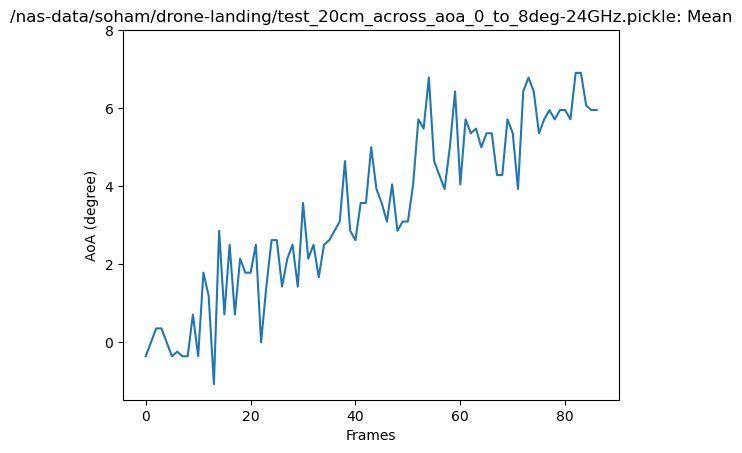

In [71]:
plt.plot(mean_AoA_array)
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks([0, 2, 4, 6, 8])
plt.title(f"{filename}: Mean")

In [73]:
filename = "/nas-data/soham/drone-landing/straight_178cm_right_61cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

mode_AoA_array = []
mean_AoA_array = []
for i in range(2, 85):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)

frame = 2, aoa_list = [-45.         -45.         -12.14285714 -45.        ]
frame = 3, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 4, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 5, aoa_list = [-45. -45. -15. -45.]
frame = 6, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 7, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 8, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 9, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 10, aoa_list = [-45. -45. -15. -45.]
frame = 11, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 12, aoa_list = [-45. -45. -15. -45.]
frame = 13, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 14, aoa_list = [-45. -45. -15. -45.]
frame = 15, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 16, aoa_list = [-45.         -45.         -13.5714

Text(0.5, 1.0, '/nas-data/soham/drone-landing/straight_178cm_right_61cm_H-24GHz.pickle: Mean')

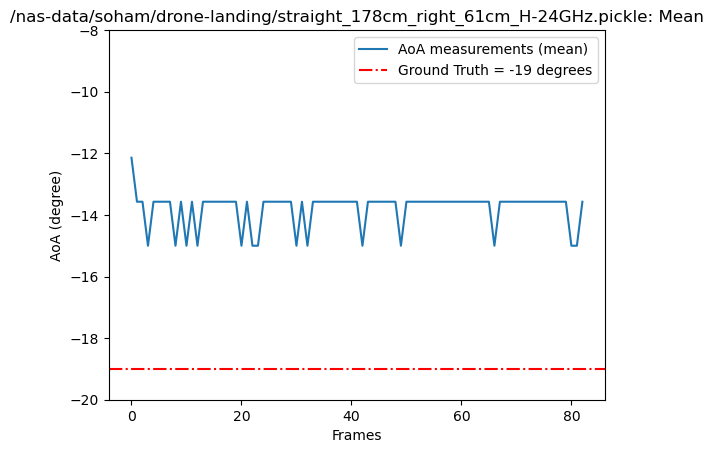

In [75]:
plt.plot(mean_AoA_array, label='AoA measurements (mean)')
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks([-20, -18, -16, -14, -12, -10, -8])
plt.axhline(y=-19, linestyle="-.", color='r', label = "Ground Truth = -19 degrees")
plt.legend()
plt.title(f"{filename}: Mean")

In [77]:
filename = "/nas-data/soham/drone-landing/straight_178cm_right_122cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

mode_AoA_array = []
mean_AoA_array = []
for i in range(2, 25):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)


frame = 2, aoa_list = [-45.          22.14285714 -27.85714286 -39.28571429]
frame = 3, aoa_list = [  6.42857143  -7.85714286 -16.42857143  -7.85714286]
frame = 4, aoa_list = [-45.         -45.         -22.14285714  42.14285714]
frame = 5, aoa_list = [-45.         -45.         -26.42857143 -36.42857143]
frame = 6, aoa_list = [ -5.         -45.         -26.42857143 -45.        ]
frame = 7, aoa_list = [-45.         -45.         -26.42857143  36.42857143]
frame = 8, aoa_list = [ -2.14285714 -45.         -26.42857143  32.14285714]
frame = 9, aoa_list = [-45.          13.57142857 -26.42857143 -45.        ]
frame = 10, aoa_list = [-45.         -45.         -26.42857143 -45.        ]
frame = 11, aoa_list = [-45.         -13.57142857 -26.42857143 -36.42857143]
frame = 12, aoa_list = [-45.         -45.         -26.42857143  27.85714286]
frame = 13, aoa_list = [-45.         -45.         -26.42857143  10.71428571]
frame = 14, aoa_list = [-45.          29.28571429 -26.42857143  33.57142857]
frame =

Text(0.5, 1.0, '/nas-data/soham/drone-landing/straight_178cm_right_122cm_H-24GHz.pickle: Mean')

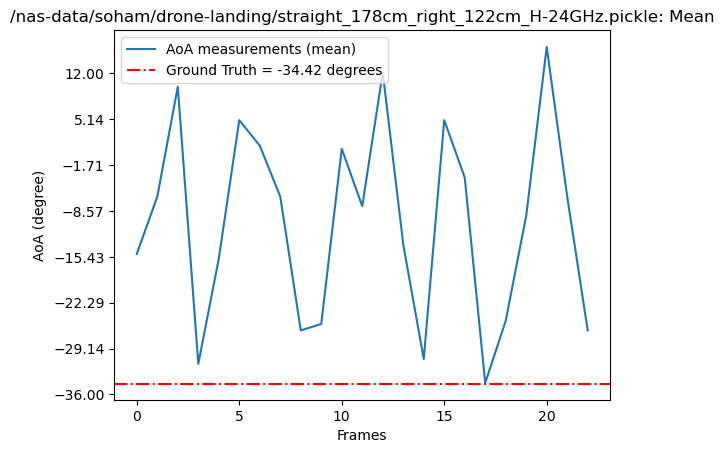

In [78]:
plt.plot(mean_AoA_array, label='AoA measurements (mean)')
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks(np.linspace(-36, 12, 8))
plt.axhline(y=-34.42, linestyle="-.", color='r', label = "Ground Truth = -34.42 degrees")
plt.legend()
plt.title(f"{filename}: Mean")

In [79]:
filename = "/nas-data/soham/drone-landing/straight_178cm_right_61cm_V-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

mode_AoA_array = []
mean_AoA_array = []
for i in range(2, 10):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)

frame = 2, aoa_list = [7.85714286 9.28571429 7.85714286 9.28571429]
frame = 3, aoa_list = [-27.85714286  13.57142857   7.85714286   5.        ]
frame = 4, aoa_list = [-16.42857143 -25.         -29.28571429  27.85714286]
frame = 5, aoa_list = [-7.85714286 26.42857143 37.85714286 17.85714286]
frame = 6, aoa_list = [ 39.28571429 -10.71428571 -35.          -0.71428571]
frame = 7, aoa_list = [-15.          20.71428571 -16.42857143  39.28571429]
frame = 8, aoa_list = [ 32.14285714 -36.42857143  -0.71428571  13.57142857]
frame = 9, aoa_list = [ 3.57142857 10.71428571 33.57142857 10.71428571]


In [80]:
mode_AoA_array = []
mean_AoA_array = []
f_tags = [156, 625]           # A, D
for i in range(2, 85):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size, f_tags=f_tags)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)

frame = 2, aoa_list = [7.85714286 6.42857143]
frame = 3, aoa_list = [33.57142857 43.57142857]
frame = 4, aoa_list = [-13.57142857  10.71428571]
frame = 5, aoa_list = [29.28571429  0.71428571]
frame = 6, aoa_list = [-35.           3.57142857]
frame = 7, aoa_list = [-27.85714286  -2.14285714]
frame = 8, aoa_list = [29.28571429 35.        ]
frame = 9, aoa_list = [13.57142857 19.28571429]
frame = 10, aoa_list = [-10.71428571   2.14285714]
frame = 11, aoa_list = [19.28571429 -9.28571429]
frame = 12, aoa_list = [ 5.         19.28571429]
frame = 13, aoa_list = [-45.         -22.14285714]
frame = 14, aoa_list = [23.57142857 15.        ]
frame = 15, aoa_list = [-7.85714286  7.85714286]
frame = 16, aoa_list = [-23.57142857 -45.        ]
frame = 17, aoa_list = [19.28571429 45.        ]
frame = 18, aoa_list = [  9.28571429 -12.14285714]
frame = 19, aoa_list = [ 22.14285714 -19.28571429]
frame = 20, aoa_list = [-19.28571429  26.42857143]
frame = 21, aoa_list = [-17.85714286 -12.14285714]
frame = 22

In [ ]:
def get_angle_framewise_windowless(frame, freq_min, freq_max, chirp_slope, period, frame_size, f_tags = [183, 337, 250, 127], nfft=2**8, num_rx=4, c=2.98e8):
    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max)
    RD = get_RD(RP)
    AOA_norm = angle_fft_windowless(RD, nfft=64)
    # f_tags = [183, 337, 250, 127]
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    for i in range(len(f_tags)):
        # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])
        
        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)

    max_idxs = max_idxs.astype(int)
    target_idx = int(np.mean(max_idxs))
    RD_slice = np.abs(RD[target_idx, :, 0])
    doppler_max = (8.69*255)/2
    doppler_min = -doppler_max 
    doppler_freqs = np.linspace(doppler_min, doppler_max, num = 256)
    f_tags = np.array(f_tags)
    diff = np.abs(doppler_freqs[None, :] - f_tags[:, None])

    # For each f_tag (row), find the index of the closest doppler_freq
    closest_doppler_indices = np.argmin(diff, axis=1)
    AoA_vals = np.linspace(-45, 45, num=64) # 64-point FFT 
 
    freq_aoa_dict = {}
    for i in range(len(closest_doppler_indices)):
        target_freq_idx = closest_doppler_indices[i] 
        AoA_range_freq = AOA_norm[target_idx, target_freq_idx, :]
        AoA_idx = np.argmax(AoA_range_freq)
        AoA = AoA_vals[AoA_idx]
        freq_aoa_dict[doppler_freqs[target_freq_idx]] = AoA

    aoa_list = np.array(list(freq_aoa_dict.values()))
    mode_aoa = scipy.stats.mode(aoa_list[aoa_list!=-45]).mode
    mean_aoa = np.mean(aoa_list[aoa_list!=-45])
    return mean_aoa, mode_aoa, aoa_list


In [ ]:
filename = "/nas-data/soham/drone-landing/straight_178cm_right_122cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

mode_AoA_array = []
mean_AoA_array = []
for i in range(2, 85):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise_windowless(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)

frame = 2, aoa_list = [  0.71428571 -45.         -27.85714286 -45.        ]
frame = 3, aoa_list = [ 17.85714286 -22.14285714 -23.57142857 -19.28571429]
frame = 4, aoa_list = [ -9.28571429  -2.14285714 -26.42857143 -45.        ]
frame = 5, aoa_list = [ 27.85714286  29.28571429 -27.85714286 -45.        ]
frame = 6, aoa_list = [ 17.85714286   0.71428571 -26.42857143 -45.        ]
frame = 7, aoa_list = [-45.         -22.14285714 -26.42857143 -45.        ]
frame = 8, aoa_list = [  6.42857143 -45.         -26.42857143  33.57142857]
frame = 9, aoa_list = [-45.          20.71428571 -26.42857143  27.85714286]
frame = 10, aoa_list = [ 32.14285714 -45.         -26.42857143 -45.        ]
frame = 11, aoa_list = [  9.28571429 -45.         -26.42857143 -45.        ]
frame = 12, aoa_list = [-36.42857143  25.         -26.42857143  26.42857143]
frame = 13, aoa_list = [ 40.71428571  43.57142857 -25.         -12.14285714]
frame = 14, aoa_list = [-45.          26.42857143 -26.42857143 -37.85714286]
frame =

Text(0.5, 1.0, './data/straight_178cm_right_122cm_H-24GHz.pickle: Mean')

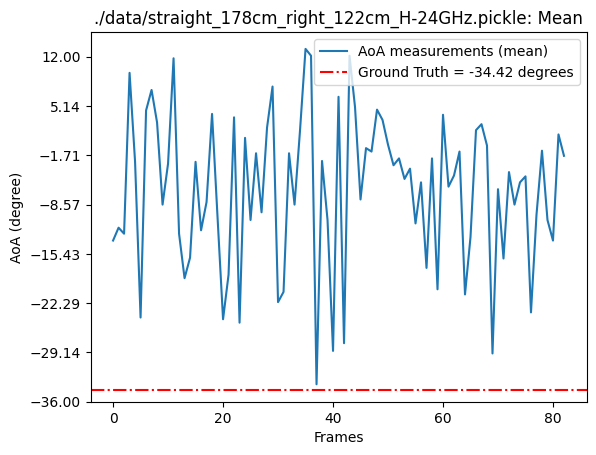

In [ ]:
plt.plot(mean_AoA_array, label='AoA measurements (mean)')
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks(np.linspace(-36, 12, 8))
plt.axhline(y=-34.42, linestyle="-.", color='r', label = "Ground Truth = -34.42 degrees")
plt.legend()
plt.title(f"{filename}: Mean")

In [ ]:
filename = "/nas-data/soham/drone-landing/straight_178cm_right_61cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

mode_AoA_array = []
mean_AoA_array = []
for i in range(2, 85):        # starts from frame 2
    data_framewise = data_raw[:,i,:]
    mean_aoa, mode_aoa, aoa_list = get_angle_framewise_windowless(data_framewise, freq_min, freq_max, chirp_slope, period, frame_size)
    print(f"frame = {i}, aoa_list = {aoa_list}")
    mode_AoA_array.append(mode_aoa)
    mean_AoA_array.append(mean_aoa)

frame = 2, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 3, aoa_list = [-45. -45. -15. -45.]
frame = 4, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 5, aoa_list = [-45. -45. -15. -45.]
frame = 6, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 7, aoa_list = [-45. -45. -15. -45.]
frame = 8, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 9, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 10, aoa_list = [-45. -45. -15. -45.]
frame = 11, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 12, aoa_list = [-45. -45. -15. -45.]
frame = 13, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 14, aoa_list = [-45. -45. -15. -45.]
frame = 15, aoa_list = [-45.         -45.         -13.57142857 -45.        ]
frame = 16, aoa_list = [-45. -45. -15. -45.]
frame = 17, aoa_list = [-45.         -45.         -13.57142857 -45.        ]


Text(0.5, 1.0, './data/straight_178cm_right_61cm_H-24GHz.pickle: Mean')

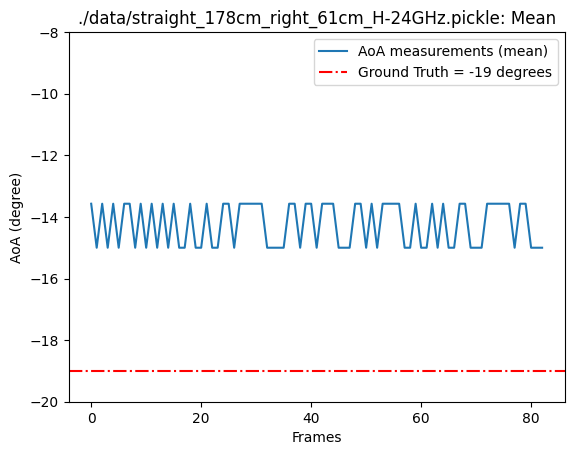

In [ ]:
plt.plot(mean_AoA_array, label='AoA measurements (mean)')
plt.xlabel("Frames")
plt.ylabel("AoA (degree)")
plt.yticks([-20, -18, -16, -14, -12, -10, -8])
plt.axhline(y=-19, linestyle="-.", color='r', label = "Ground Truth = -19 degrees")
plt.legend()
plt.title(f"{filename}: Mean")

In [ ]:
filename = "/nas-data/soham/drone-landing/straight_178cm_right_61cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

for j in range(50):
    frame = data_raw[:,j,:]

    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max)
    RD = get_RD(RP)
    AOA_norm = angle_fft_windowless(RD, nfft=64)
    # f_tags = [183, 337, 250, 127]
    f_tags = np.array([156, 250, 313, 625])
    face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    max_corrs = np.zeros(len(f_tags))
    for i in range(len(f_tags)):
    # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)

        # take the max correlation for each tag 
        max_corrs[i] = np.max(correlation)
    
    # apply correlation threshold of 2e6
    corr_thresh = 2e6
    f_detected = f_tags[max_corrs > corr_thresh]
    faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    print(f"Frame = {j}, Detected faces = {faces_detected}")

# 156, 250, 313, 625 : A, B, C, D

Frame = 0, Detected faces = ['B', 'D']
Frame = 1, Detected faces = ['B', 'D']
Frame = 2, Detected faces = ['B', 'D']
Frame = 3, Detected faces = ['B', 'D']
Frame = 4, Detected faces = ['B', 'D']
Frame = 5, Detected faces = ['B', 'D']
Frame = 6, Detected faces = ['B', 'D']
Frame = 7, Detected faces = ['B', 'D']
Frame = 8, Detected faces = ['B', 'D']
Frame = 9, Detected faces = ['B', 'D']
Frame = 10, Detected faces = ['B', 'D']
Frame = 11, Detected faces = ['B', 'D']
Frame = 12, Detected faces = ['B', 'D']
Frame = 13, Detected faces = ['B', 'D']
Frame = 14, Detected faces = ['B', 'D']
Frame = 15, Detected faces = ['B', 'D']
Frame = 16, Detected faces = ['B', 'D']
Frame = 17, Detected faces = ['B', 'D']
Frame = 18, Detected faces = ['B', 'D']
Frame = 19, Detected faces = ['B', 'D']
Frame = 20, Detected faces = ['B', 'D']
Frame = 21, Detected faces = ['B', 'D']
Frame = 22, Detected faces = ['B', 'D']
Frame = 23, Detected faces = ['B', 'D']
Frame = 24, Detected faces = ['B', 'D']
Frame = 25

In [ ]:
filename = "/nas-data/soham/drone-landing/straight_178cm_right_61cm_V-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

for j in range(50):
    frame = data_raw[:,j,:]

    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max)
    RD = get_RD(RP)
    AOA_norm = angle_fft_windowless(RD, nfft=64)
    # f_tags = [183, 337, 250, 127]
    f_tags = np.array([156, 250, 313, 625])
    face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    max_corrs = np.zeros(len(f_tags))
    for i in range(len(f_tags)):
    # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)

        # take the max correlation for each tag 
        max_corrs[i] = np.max(correlation)
    
    # apply correlation threshold of 2e6
    corr_thresh = 2e6
    f_detected = f_tags[max_corrs > corr_thresh]
    faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    print(f"Frame = {j}, Detected faces = {faces_detected}")

# 156, 250, 313, 625 : A, B, C, D

Frame = 0, Detected faces = []
Frame = 1, Detected faces = []
Frame = 2, Detected faces = []
Frame = 3, Detected faces = []
Frame = 4, Detected faces = []
Frame = 5, Detected faces = []
Frame = 6, Detected faces = []
Frame = 7, Detected faces = []
Frame = 8, Detected faces = []
Frame = 9, Detected faces = []
Frame = 10, Detected faces = []
Frame = 11, Detected faces = []
Frame = 12, Detected faces = []
Frame = 13, Detected faces = []
Frame = 14, Detected faces = []
Frame = 15, Detected faces = []
Frame = 16, Detected faces = []
Frame = 17, Detected faces = []
Frame = 18, Detected faces = []
Frame = 19, Detected faces = []
Frame = 20, Detected faces = []
Frame = 21, Detected faces = []
Frame = 22, Detected faces = []
Frame = 23, Detected faces = []
Frame = 24, Detected faces = []
Frame = 25, Detected faces = []
Frame = 26, Detected faces = []
Frame = 27, Detected faces = []
Frame = 28, Detected faces = []
Frame = 29, Detected faces = []
Frame = 30, Detected faces = []
Frame = 31, Detect

In [ ]:
filename = "/nas-data/soham/drone-landing/straight_200cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c

for j in range(20):
    frame = data_raw[:,j,:]

    data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
    RP = get_RP(data_frame_reshaped, freq_min, freq_max)
    RD = get_RD(RP)
    AOA_norm = angle_fft_windowless(RD, nfft=64)
    # f_tags = [183, 337, 250, 127]
    f_tags = np.array([156, 250, 313, 625])
    face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
    max_idxs = np.zeros(len(f_tags))
    freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
    range_steps = freq_steps * c / 2 / chirp_slope
    max_corrs = np.zeros(len(f_tags))
    for i in range(len(f_tags)):
    # generate the template for that particular tag face
        template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

        # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
        correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

        # get the range index of the highest correlation
        max_idxs[i] = np.argmax(correlation)

        # take the max correlation for each tag 
        max_corrs[i] = np.max(correlation)
    
    # apply correlation threshold of 2e6
    # corr_thresh = 2e6
    # corr_thresh = 4.5e5
    corr_thresh = 2.5e5
    f_detected = f_tags[max_corrs > corr_thresh]
    faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    ftag_corr_dict = {f_tags[0]: max_corrs[0], f_tags[1]: max_corrs[1], f_tags[2]: max_corrs[2], f_tags[3]: max_corrs[3]}
    clean_dict = {int(k): float(v) for k, v in ftag_corr_dict.items()}

    # print(f"Frame = {j}, Detected faces = {faces_detected}")
    print(f"Frame = {j}, f_tag_corr_dict = {clean_dict}")

# 156, 250, 313, 625 : A, B, C, D

Frame = 0, f_tag_corr_dict = {156: 406365.65317680576, 250: 792462.6250074804, 313: 405662.86457920243, 625: 1320773.0197984076}
Frame = 1, f_tag_corr_dict = {156: 422815.87379285746, 250: 783719.7668203777, 313: 487266.97630781465, 625: 1332533.5033600868}
Frame = 2, f_tag_corr_dict = {156: 449985.7084036137, 250: 810650.003036645, 313: 532446.3800189637, 625: 1387902.95973441}
Frame = 3, f_tag_corr_dict = {156: 469499.88275672455, 250: 830256.5513849931, 313: 551705.0301040456, 625: 1326661.0070490963}
Frame = 4, f_tag_corr_dict = {156: 431264.56037203054, 250: 787254.4533411181, 313: 458323.7534570984, 625: 1298639.459037425}
Frame = 5, f_tag_corr_dict = {156: 496398.6708839958, 250: 816710.8568139736, 313: 503792.7133256149, 625: 1312682.131504886}
Frame = 6, f_tag_corr_dict = {156: 487501.3693282425, 250: 777264.9393135795, 313: 483446.97953542, 625: 1302239.6709944194}
Frame = 7, f_tag_corr_dict = {156: 606455.074435052, 250: 957107.7391156213, 313: 499034.9800398403, 625: 144924

In [81]:
filename = "/nas-data/soham/drone-landing/straight_200cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c


frame = data_raw[:,50,:]

data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
RP = get_RP(data_frame_reshaped, freq_min, freq_max)
RD = get_RD(RP)
AOA_norm = angle_fft_windowless(RD, nfft=64)
# f_tags = [183, 337, 250, 127]
# f_tags = np.array([156, 250, 313, 625])
f_tags = np.linspace(100, 750, 650, endpoint=True)           # trying to see how the correlation values look like across frequencies
face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
max_idxs = np.zeros(len(f_tags))
freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
range_steps = freq_steps * c / 2 / chirp_slope
max_corrs = np.zeros(len(f_tags))
for i in range(len(f_tags)):
# generate the template for that particular tag face
    template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

    # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
    correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

    # get the range index of the highest correlation
    max_idxs[i] = np.argmax(correlation)

    # take the max correlation for each tag 
    max_corrs[i] = np.max(correlation)    

    # apply correlation threshold of 2e6
    # corr_thresh = 2e6
    # corr_thresh = 4.5e5
    # corr_thresh = 2.5e5
    # f_detected = f_tags[max_corrs > corr_thresh]
    # faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    # ftag_corr_dict = {f_tags[0]: max_corrs[0], f_tags[1]: max_corrs[1], f_tags[2]: max_corrs[2], f_tags[3]: max_corrs[3]}
    # clean_dict = {int(k): float(v) for k, v in ftag_corr_dict.items()}

    # print(f"Frame = {j}, Detected faces = {faces_detected}")
    # print(f"Frame = {j}, f_tag_corr_dict = {clean_dict}")

# 156, 250, 313, 625 : A, B, C, D

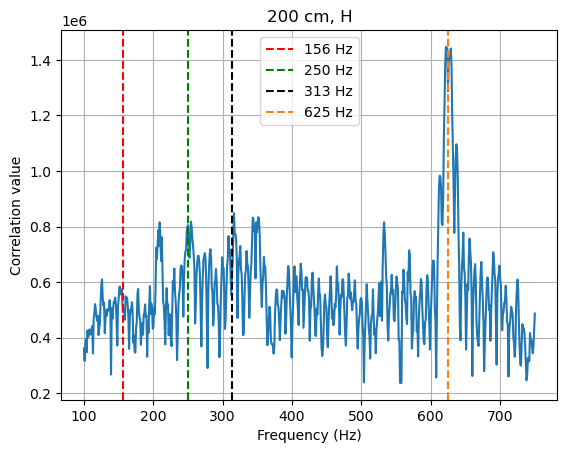

In [82]:
plt.plot(f_tags, max_corrs)
plt.axvline(x=156, linestyle="--", color='r', label='156 Hz')
plt.axvline(x=250, linestyle="--", color='g', label='250 Hz')
plt.axvline(x=313, linestyle="--", color='black', label='313 Hz')
plt.axvline(x=625, linestyle="--", color='tab:orange', label='625 Hz')
plt.title("200 cm, H")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation value")
plt.grid()
plt.legend()

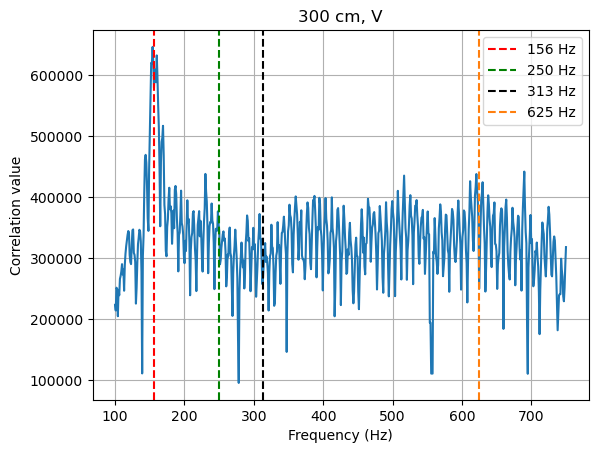

In [84]:
filename = "/nas-data/soham/drone-landing/straight_300cm_V-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c


frame = data_raw[:,50,:]

data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
RP = get_RP(data_frame_reshaped, freq_min, freq_max)
RD = get_RD(RP)
AOA_norm = angle_fft_windowless(RD, nfft=64)
# f_tags = [183, 337, 250, 127]
# f_tags = np.array([156, 250, 313, 625])
f_tags = np.linspace(100, 750, 650, endpoint=True)           # trying to see how the correlation values look like across frequencies
face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
max_idxs = np.zeros(len(f_tags))
freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
range_steps = freq_steps * c / 2 / chirp_slope
max_corrs = np.zeros(len(f_tags))
for i in range(len(f_tags)):
# generate the template for that particular tag face
    template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

    # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
    correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

    # get the range index of the highest correlation
    max_idxs[i] = np.argmax(correlation)

    # take the max correlation for each tag 
    max_corrs[i] = np.max(correlation)    

    # apply correlation threshold of 2e6
    # corr_thresh = 2e6
    # corr_thresh = 4.5e5
    # corr_thresh = 2.5e5
    # f_detected = f_tags[max_corrs > corr_thresh]
    # faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    # ftag_corr_dict = {f_tags[0]: max_corrs[0], f_tags[1]: max_corrs[1], f_tags[2]: max_corrs[2], f_tags[3]: max_corrs[3]}
    # clean_dict = {int(k): float(v) for k, v in ftag_corr_dict.items()}

    # print(f"Frame = {j}, Detected faces = {faces_detected}")
    # print(f"Frame = {j}, f_tag_corr_dict = {clean_dict}")

# 156, 250, 313, 625 : A, B, C, D

plt.plot(f_tags, max_corrs)
plt.axvline(x=156, linestyle="--", color='r', label='156 Hz')
plt.axvline(x=250, linestyle="--", color='g', label='250 Hz')
plt.axvline(x=313, linestyle="--", color='black', label='313 Hz')
plt.axvline(x=625, linestyle="--", color='tab:orange', label='625 Hz')
plt.title("300 cm, V")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation value")
plt.grid()
plt.legend()

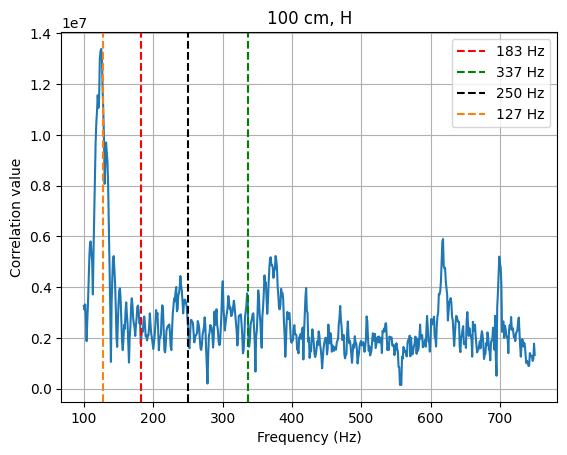

In [ ]:
f_tags_known = [183, 337, 250, 127]

plt.plot(f_tags, max_corrs)
plt.axvline(x=183, linestyle="--", color='r', label='183 Hz')
plt.axvline(x=337, linestyle="--", color='g', label='337 Hz')
plt.axvline(x=250, linestyle="--", color='black', label='250 Hz')
plt.axvline(x=127, linestyle="--", color='tab:orange', label='127 Hz')
plt.title("100 cm, H")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation value")
plt.grid()
plt.legend()

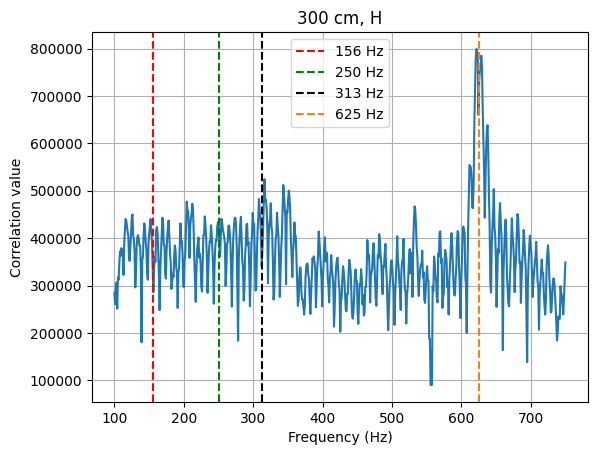

In [ ]:
filename = "/nas-data/soham/drone-landing/straight_300cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c


frame = data_raw[:,50,:]

data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
RP = get_RP(data_frame_reshaped, freq_min, freq_max)
RD = get_RD(RP)
AOA_norm = angle_fft_windowless(RD, nfft=64)
# f_tags = [183, 337, 250, 127]
# f_tags = np.array([156, 250, 313, 625])
f_tags = np.linspace(100, 750, 650, endpoint=True)           # trying to see how the correlation values look like across frequencies
face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
max_idxs = np.zeros(len(f_tags))
freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
range_steps = freq_steps * c / 2 / chirp_slope
max_corrs = np.zeros(len(f_tags))
for i in range(len(f_tags)):
# generate the template for that particular tag face
    template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

    # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
    correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

    # get the range index of the highest correlation
    max_idxs[i] = np.argmax(correlation)

    # take the max correlation for each tag 
    max_corrs[i] = np.max(correlation)    

    # apply correlation threshold of 2e6
    # corr_thresh = 2e6
    # corr_thresh = 4.5e5
    # corr_thresh = 2.5e5
    # f_detected = f_tags[max_corrs > corr_thresh]
    # faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    # ftag_corr_dict = {f_tags[0]: max_corrs[0], f_tags[1]: max_corrs[1], f_tags[2]: max_corrs[2], f_tags[3]: max_corrs[3]}
    # clean_dict = {int(k): float(v) for k, v in ftag_corr_dict.items()}

    # print(f"Frame = {j}, Detected faces = {faces_detected}")
    # print(f"Frame = {j}, f_tag_corr_dict = {clean_dict}")

# 156, 250, 313, 625 : A, B, C, D

plt.plot(f_tags, max_corrs)
plt.axvline(x=156, linestyle="--", color='r', label='156 Hz')
plt.axvline(x=250, linestyle="--", color='g', label='250 Hz')
plt.axvline(x=313, linestyle="--", color='black', label='313 Hz')
plt.axvline(x=625, linestyle="--", color='tab:orange', label='625 Hz')
plt.title("300 cm, H")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation value")
plt.grid()
plt.legend()

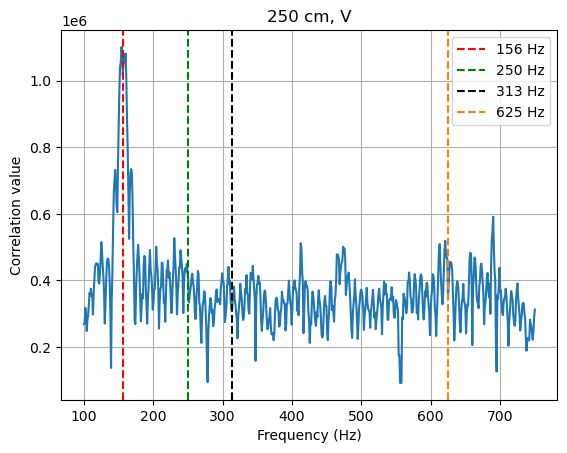

In [86]:
filename = "/nas-data/soham/drone-landing/straight_250cm_V-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c


frame = data_raw[:,50,:]

data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
RP = get_RP(data_frame_reshaped, freq_min, freq_max)
RD = get_RD(RP)
AOA_norm = angle_fft_windowless(RD, nfft=64)
# f_tags = [183, 337, 250, 127]
# f_tags = np.array([156, 250, 313, 625])
f_tags = np.linspace(100, 750, 650, endpoint=True)           # trying to see how the correlation values look like across frequencies
face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
max_idxs = np.zeros(len(f_tags))
freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
range_steps = freq_steps * c / 2 / chirp_slope
max_corrs = np.zeros(len(f_tags))
for i in range(len(f_tags)):
# generate the template for that particular tag face
    template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

    # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
    correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

    # get the range index of the highest correlation
    max_idxs[i] = np.argmax(correlation)

    # take the max correlation for each tag 
    max_corrs[i] = np.max(correlation)    

    # apply correlation threshold of 2e6
    # corr_thresh = 2e6
    # corr_thresh = 4.5e5
    # corr_thresh = 2.5e5
    # f_detected = f_tags[max_corrs > corr_thresh]
    # faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    # ftag_corr_dict = {f_tags[0]: max_corrs[0], f_tags[1]: max_corrs[1], f_tags[2]: max_corrs[2], f_tags[3]: max_corrs[3]}
    # clean_dict = {int(k): float(v) for k, v in ftag_corr_dict.items()}

    # print(f"Frame = {j}, Detected faces = {faces_detected}")
    # print(f"Frame = {j}, f_tag_corr_dict = {clean_dict}")

# 156, 250, 313, 625 : A, B, C, D

plt.plot(f_tags, max_corrs)
plt.axvline(x=156, linestyle="--", color='r', label='156 Hz')
plt.axvline(x=250, linestyle="--", color='g', label='250 Hz')
plt.axvline(x=313, linestyle="--", color='black', label='313 Hz')
plt.axvline(x=625, linestyle="--", color='tab:orange', label='625 Hz')
plt.title("250 cm, V")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation value")
plt.grid()
plt.legend()

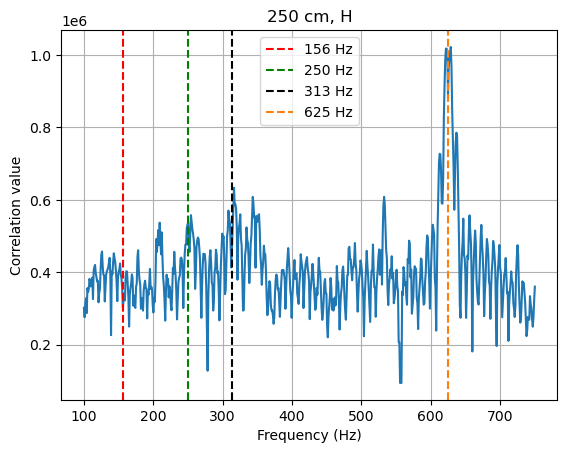

In [87]:
filename = "/nas-data/soham/drone-landing/straight_250cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw = data_raw_V['Data']
fs = 1e6
c = 3e8

cfg = data_raw_V['Cfg']
frame_size = cfg['FrmMeasSiz']  # Num chirps per frame
N = cfg['N']  # Num samples per chirp
chirp_slope = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']  # Chirp slope
period = cfg['Perd']
freq_min = 2*range_min * chirp_slope / c
freq_max = 2*range_max * chirp_slope / c


frame = data_raw[:,50,:]

data_frame_reshaped = frameReshape(frame, numLoopsPerFrame=frame_size, numRxAntennas=num_rx)
RP = get_RP(data_frame_reshaped, freq_min, freq_max)
RD = get_RD(RP)
AOA_norm = angle_fft_windowless(RD, nfft=64)
# f_tags = [183, 337, 250, 127]
# f_tags = np.array([156, 250, 313, 625])
f_tags = np.linspace(100, 750, 650, endpoint=True)           # trying to see how the correlation values look like across frequencies
face_freq_dict = {'A': 156, 'B': 250, 'C': 313, 'D': 625}
max_idxs = np.zeros(len(f_tags))
freq_steps = np.linspace(0, nfft, nfft, endpoint=True)/nfft * (freq_max - freq_min) + freq_min
range_steps = freq_steps * c / 2 / chirp_slope
max_corrs = np.zeros(len(f_tags))
for i in range(len(f_tags)):
# generate the template for that particular tag face
    template = generate_template(period=period, frame_size=frame_size, nfft=nfft, f_tag=f_tags[i])

    # we can choose any antenna for performing the correlation -- or maybe look into combining all the antennas
    correlation = np.sum(np.abs(RD[:,:,0]) * np.repeat(np.abs(template[:, np.newaxis]), nfft, axis=1).T, axis=1) #basically dot product

    # get the range index of the highest correlation
    max_idxs[i] = np.argmax(correlation)

    # take the max correlation for each tag 
    max_corrs[i] = np.max(correlation)    

    # apply correlation threshold of 2e6
    # corr_thresh = 2e6
    # corr_thresh = 4.5e5
    # corr_thresh = 2.5e5
    # f_detected = f_tags[max_corrs > corr_thresh]
    # faces_detected = [face for face, freq in face_freq_dict.items() if freq in f_detected]

    # ftag_corr_dict = {f_tags[0]: max_corrs[0], f_tags[1]: max_corrs[1], f_tags[2]: max_corrs[2], f_tags[3]: max_corrs[3]}
    # clean_dict = {int(k): float(v) for k, v in ftag_corr_dict.items()}

    # print(f"Frame = {j}, Detected faces = {faces_detected}")
    # print(f"Frame = {j}, f_tag_corr_dict = {clean_dict}")

# 156, 250, 313, 625 : A, B, C, D

plt.plot(f_tags, max_corrs)
plt.axvline(x=156, linestyle="--", color='r', label='156 Hz')
plt.axvline(x=250, linestyle="--", color='g', label='250 Hz')
plt.axvline(x=313, linestyle="--", color='black', label='313 Hz')
plt.axvline(x=625, linestyle="--", color='tab:orange', label='625 Hz')
plt.title("250 cm, H")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Correlation value")
plt.grid()
plt.legend()

In [3]:
filename = "/nas-data/soham/drone-landing/straight_250cm_H-24GHz.pickle"
data_raw_V = pickle.load(open(filename, 'rb'))
data_raw_V.keys()

dict_keys(['Data', 'dtime', 'Cfg', 'N', 'NrChn', 'fs', 'measRounds', 'CalDat', 'switchPer', 'chirpDur'])

In [6]:
data_raw_V['CalDat']

array([1.07092643+0.05503416j, 1.18740213+0.11046427j,
       0.91842884+0.27887893j, 1.        +0.j        ,
       0.98314106-0.04957449j, 0.95501363-0.08414447j,
       0.93526685+0.05461562j, 0.94538003-0.11375439j])